# MIRA HSC analysis

In [1]:
import mira
import optuna
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import seaborn as sns
mira.logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.simplefilter("ignore")

umap_kwargs = dict(
    add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
    legend_fontweight=350, frameon = False, legend_fontsize=12, figsize=(10,10)
)
print(mira.__version__)
mira.utils.pretty_sderr()

sc.set_figure_params(scanpy=True, dpi=200, dpi_save=300, 
                          fontsize=14, figsize=(10,10))
                  

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


1.0.4


# NITE modeling on the HSC data

In [132]:
#import the raw RNA and raw ATAC data 
atac = anndata.read_h5ad('Single_Cell/MIRA/ATAC_MIRA_input_HSCs_only.h5ad')
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

#remove peaks according to episcanpy tutorial
sc.pp.filter_genes(atac, min_cells=1)
atac.var['log_counts_cells'] = [np.log10(x) for x in atac.var['n_cells_by_counts']]
subset = atac.var[atac.var['log_counts_cells']>1]
subset['peak'] = subset.index
subset_peaks = list(subset['peak'])
to_keep = atac.var_names.isin(subset_peaks)
atac = atac[:,to_keep]
atac.raw = atac

#select endog
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)

sc.pp.highly_variable_genes(atac, min_disp = 0.05)
atac.var['exog'] = atac.var.highly_variable.copy()
atac.var['endog'] = atac.var.exog & (atac.var.dispersions_norm > 0.5)
atac.layers['counts'] = atac.raw.to_adata().X.copy()

atc_model = mira.topics.AccessibilityTopicModel.load('Single_Cell/MIRA/ATAC_topic_model_HSCs_only_T21_healthy.pth')
atc_model.predict(atac)

atc_model.get_umap_features(atac, box_cox=0.99)
sc.pp.neighbors(atac, use_rep = 'X_umap_features', metric = 'manhattan', n_neighbors = 15)
sc.tl.umap(atac, min_dist = 0.1)
sc.external.pp.harmony_integrate(atac, key='dataset', 
                                 basis='X_umap_features', adjusted_basis='X_umap_features_harmony')
sc.pp.neighbors(atac, use_rep = 'X_umap_features_harmony', n_neighbors = 15)
sc.tl.umap(atac, min_dist = 0.1)

#need to add the chr, start, stop into the peak identifications 
atc_index = list(atac.var.index)
chr_list = []
start_list = []
end_list = []
for peak in atc_index:
    chro,start,end = peak.split('-')
    chr_list.append(chro)
    start_list.append(start)
    end_list.append(end)
atac.var['chr']=chr_list
atac.var['start']=start_list
atac.var['end']=end_list
atac.var = atac.var.astype({"start":"int","end":"int"})
atac.var

mira.tl.get_distance_to_TSS(atac,
                            tss_data='mira-datasets/hg38_tss_data.bed12',
                            genome_file='mira-datasets/hg38.chrom.sizes')


INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/13 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
2023-01-23 16:01:35,826 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-01-23 16:01:36,735 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-01-23 16:01:37,613 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2023-01-23 16:01:38,499 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2023-01-23 16:01:39,391

In [133]:
rna = anndata.read_h5ad('Single_Cell/MIRA/MIRA_input_HSCs_only.h5ad')

#repeat the MIRA analysis
sc.pp.filter_genes(rna, min_cells=15)
rna.raw = rna
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

#select the endogenous versus exogenous genes
sc.pp.highly_variable_genes(rna, min_disp = 0.01)
rna.var['exog'] = rna.var.highly_variable.copy()
rna.var['endog'] = rna.var.exog & (rna.var.dispersions_norm > 0.5)
rna.layers['counts'] = rna.raw.to_adata().X.copy()

model = mira.topics.ExpressionTopicModel.load('Single_Cell/MIRA/RNA_topic_model_HSC_only_T21_healthy.pth')
model.predict(rna)

model.get_umap_features(rna, box_cox=0.99)
sc.pp.neighbors(rna, use_rep = 'X_umap_features', metric = 'manhattan', n_neighbors = 15)
sc.tl.umap(rna, min_dist = 0.1, negative_sample_rate=1)
sc.external.pp.harmony_integrate(rna, key='dataset', 
                                 basis='X_umap_features', adjusted_basis='X_umap_features_harmony')
sc.pp.neighbors(rna, use_rep = 'X_umap_features_harmony', n_neighbors = 15)
sc.tl.umap(rna, min_dist = 0.1)


INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/13 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
2023-01-23 16:02:36,511 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-01-23 16:02:37,474 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-01-23 16:02:38,373 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2023-01-23 16:02:39,307 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2023-01-23 16:02:40,280 - harmony

In [134]:
#make the joint representation
rna, atac = mira.utils.make_joint_representation(rna, atac)
sc.pp.neighbors(rna, use_rep = 'X_joint_umap_features',
               n_neighbors = 15)
sc.tl.umap(rna, min_dist = 0.1)
#since they are seperating by dataset, need to batch correct
#treat X_umap_features the same as X_pca 
sc.external.pp.harmony_integrate(rna, key='dataset', 
                                 basis='X_joint_umap_features', adjusted_basis='X_joint_umap_features_harmony')
#metric ='manhattan'
sc.pp.neighbors(rna, use_rep = 'X_joint_umap_features_harmony', n_neighbors = 15)
sc.tl.umap(rna, min_dist = 0.1)

#After joining the AnnDatas, it is useful to transfer some metadata from the ATAC dataframe to the RNA dataframe 
#so that we have one main object for plotting and running other functions:
rna.obs = rna.obs.join(
    atac.obs.add_prefix('ATAC_') # add a prefix so we know which AnnData the column came from
)

atac.obsm['X_umap'] = rna.obsm['X_umap']

mira.tl.get_cell_pointwise_mutual_information(rna, atac)
mira.tl.summarize_mutual_information(rna, atac)

INFO:mira.adata_interface.utils:6215 out of 6215 cells shared between datasets (100%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features
2023-01-23 16:02:55,444 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-01-23 16:02:56,543 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-01-23 16:02:57,530 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2023-01-23 16:02:58,612 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2023-01-23 16:02:59,903 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2023-01-23 16:03:00,903 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2023-01-23 16:03:01,981 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2023-01-23 16:03:03,037 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations
INFO:mira.adata_interface.topic_model:Fetching key

0.09120377

In [135]:
#make sure its the raw counts selected
rna.layers['X_norm'] = rna.X.copy()
rna.X = rna.layers['counts'].copy()

#make sure its the raw peaks selected
atac.layers['X_norm'] = atac.X.copy()
atac.X = atac.layers['counts'].copy()

#make a dictionary of the ATAC and RNA datasets
rp_args = dict(expr_adata = rna, atac_adata= atac)

In [136]:
#load the existing LITE model
litemodel = mira.rp.LITE_Model.load_dir(
    expr_model = model,
    accessibility_model = atc_model,
    prefix='data/rpmodels/'
)

#predict
litemodel.predict(**rp_args)

#spawn the new NITE model 
nitemodel = litemodel.spawn_NITE_model()

#generate new and predict
nitemodel.fit(**rp_args, n_workers=10).predict(**rp_args)

#save the nite model itself 
!mkdir -p data/rpmodels_nite/
nitemodel.save('data/rpmodels_nite/')

#save the RNA from the NITE model prediction
mira.tl.get_chromatin_differential(rna)
rna.write('NITE_modeled_correct_RNA.h5ad')


INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/13 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/13 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/4450 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


# NITE Analysis

In [4]:
#this is the data with the NITE score calculation
ndata = anndata.read_h5ad('Single_Cell/MIRA/NITE_modeled_correct_RNA.h5ad')
ndata

AnnData object with n_obs × n_vars = 6215 × 20880
    obs: 'dataset', 'subclust_v6', 'sample', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'ATAC_dataset', 'ATAC_subclust_v6', 'ATAC_sample', 'ATAC_n_genes_by_counts', 'ATAC_total_counts', 'ATAC_topic_0', 'ATAC_topic_1', 'ATAC_topic_2', 'ATAC_topic_3', 'ATAC_topic_4', 'ATAC_topic_5', 'ATAC_topic_6', 'ATAC_topic_7', 'ATAC_topic_8', 'ATAC_topic_9', 'ATAC_topic_10', 'pointwise_mutual_information', 'model_read_scale', 'softmax_denom'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'hvg', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_joint_umap_features', 'X_joint_umap_features_harmony', 'X_topic_compositions', 'X_umap', 'X_umap_features', 'X_umap_features_harmony'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'LITE_logp', 'LITE_prediction', 'NITE_logp', 'NITE_prediction'

array([[<AxesSubplot:title={'center':'Gene'}>,
        <AxesSubplot:title={'center':'Expression'}>,
        <AxesSubplot:title={'center':'Local Prediction'}>,
        <AxesSubplot:title={'center':'Chromatin Differential'}>,
        <AxesSubplot:title={'center':'NITE vs. LITE Predictions'}, xlabel='LITE Prediction', ylabel='NITE Prediction'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='LITE Prediction', ylabel='NITE Prediction'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='LITE Prediction', ylabel='NITE Prediction'>]],
      dtype=object)

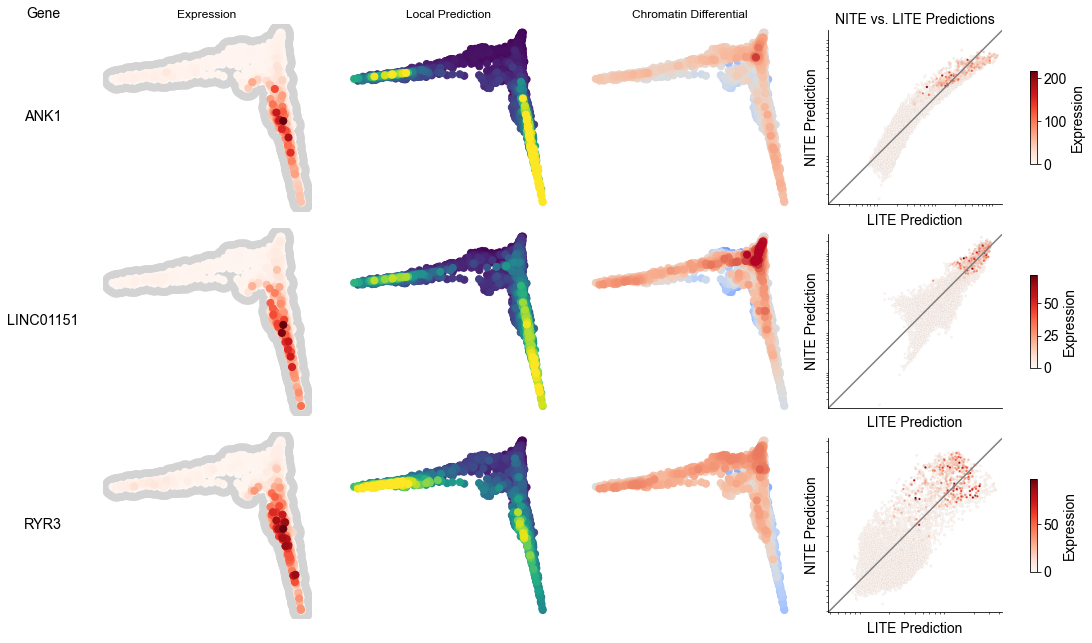

In [5]:
#check some of the genes to see the LITE versus NITE comparison
mira.pl.plot_chromatin_differential(ndata, genes = ['ANK1', 'LINC01151','RYR3'],
                                    show_legend=False, size = 50, aspect=1.2)

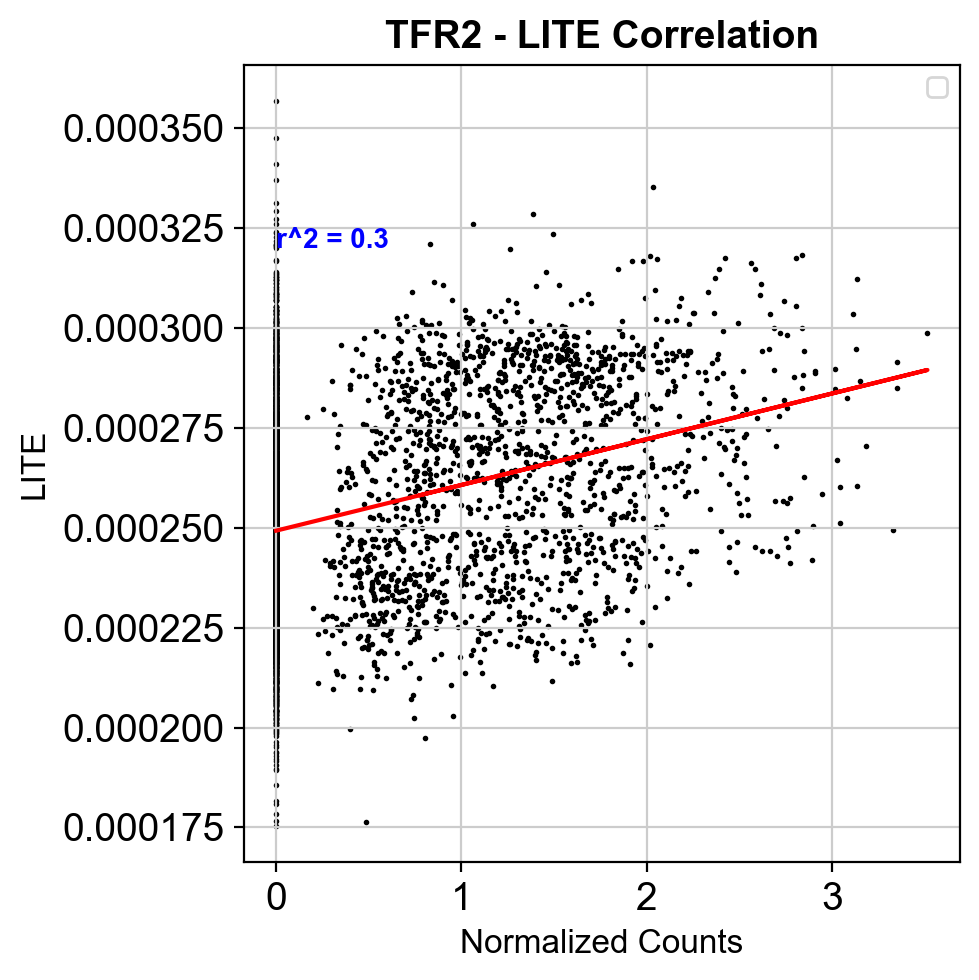

In [8]:
#TFR2, 
import scipy.sparse
from scipy import stats
import scipy as sp

gene = 'TFR2'

#create pearson correlation
sub = ndata[:, [gene]]

counts = np.array(pd.DataFrame.sparse.from_spmatrix(sub.layers['X_norm'])[0])
lite = np.array(pd.DataFrame.sparse.from_spmatrix(sub.layers['LITE_prediction'])[0])
nite = np.array(pd.DataFrame.sparse.from_spmatrix(sub.layers['NITE_prediction'])[0])

x = np.array(counts)
y = np.array(lite)
y2 = np.array(nite)

fig = plt.figure(figsize=(5,5), dpi=200)
ax = plt.subplot(111)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
plt.plot(x, line, 'r')
plt.text(0.0, 0.00032, "r^2 = "+str(round(r_value,3)), fontweight='bold', color='b')

plt.scatter(x,y, color="k", s=1)
plt.legend(fontsize=9)
plt.xlabel('Normalized Counts',fontsize=12)
plt.ylabel('LITE',fontsize=12)
plt.title( str(gene) +' - LITE Correlation',fontsize=14,fontweight='bold')

plt.tight_layout()
plt.savefig('Single_Cell/MIRA/figures/TFR2_LITE_correlation.pdf')
plt.show()

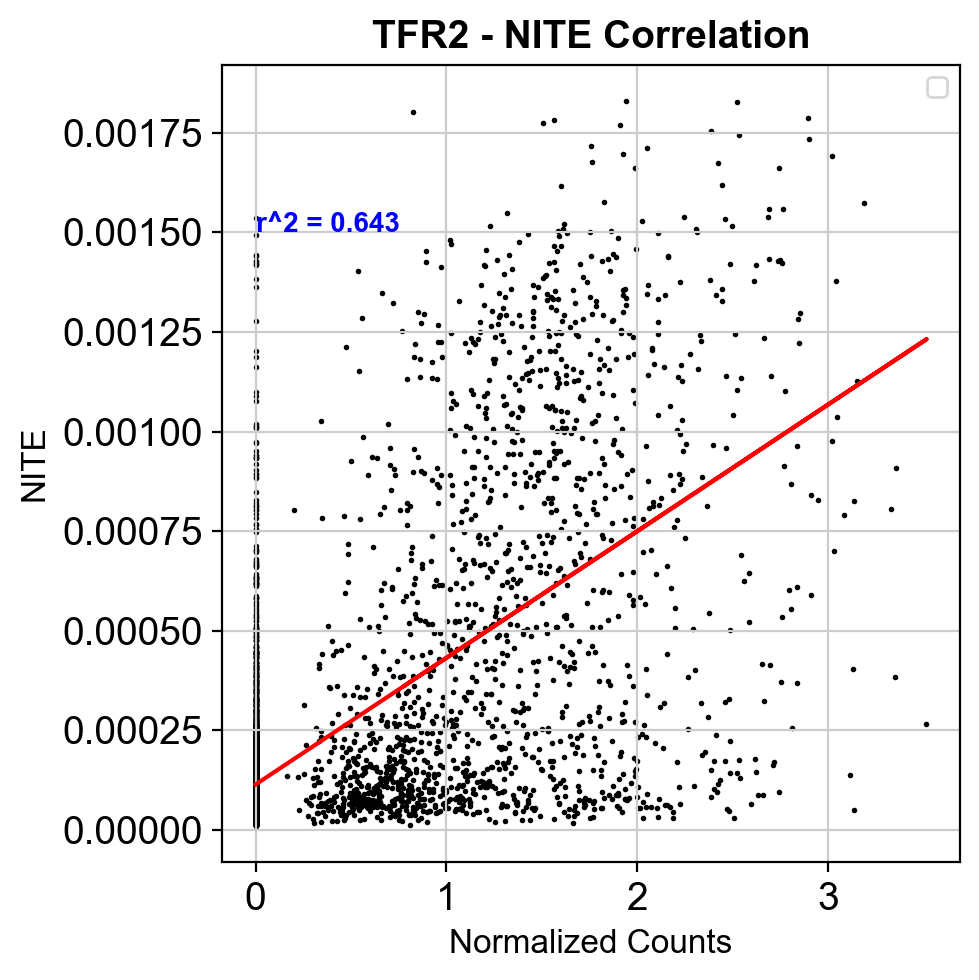

In [11]:
x = np.array(counts)
y = np.array(lite)
y2 = np.array(nite)

from scipy import stats
import scipy as sp

fig = plt.figure(figsize=(5,5), dpi=200)
ax = plt.subplot(111)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y2)

line = slope*x+intercept
plt.plot(x, line, 'r')

plt.text(0.0, 0.0015, "r^2 = "+str(round(r_value,3)), fontweight='bold', color='b')

plt.scatter(x,y2, color="k", s=1)
plt.legend(fontsize=9)
plt.xlabel('Normalized Counts',fontsize=12)
plt.ylabel('NITE',fontsize=12)
plt.title(str(gene) +' - NITE Correlation',fontsize=14,fontweight='bold')

plt.tight_layout()
plt.savefig('Single_Cell/MIRA/figures/TFR2_NITE_correlation.pdf')
plt.show()

In [12]:
#get the NITE scores for every gene
mira.tl.get_NITE_score_cells(ndata)
mira.tl.get_NITE_score_genes(ndata)

INFO:mira.adata_interface.lite_nite:Added keys to obs: NITE_score, nonzero_counts
INFO:mira.adata_interface.lite_nite:Added keys to var: NITE_score, nonzero_counts


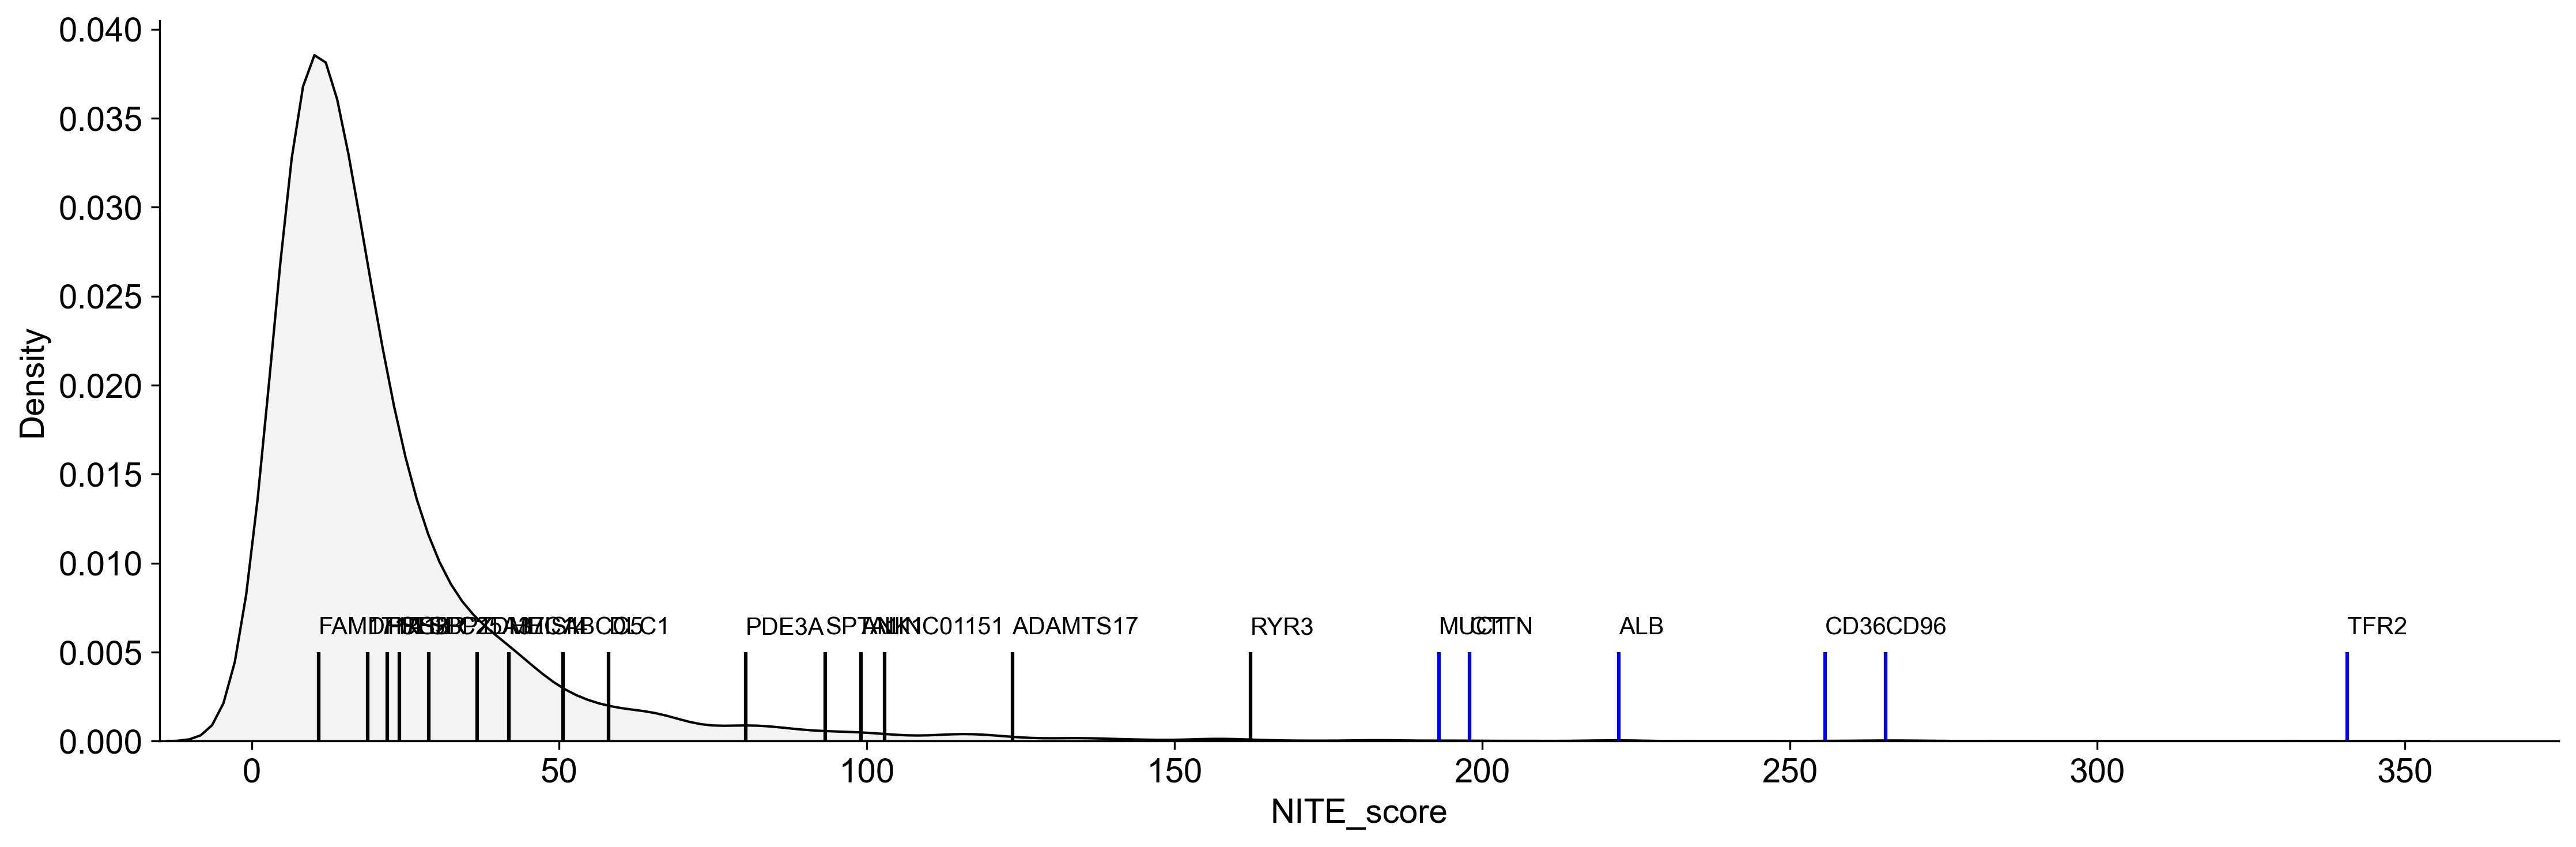

In [13]:
#plot the distribution of NITE scores for every gene and label the outliers
fig, ax = plt.subplots(1,1,figsize=(15,5), dpi=300)
gata_list = ['LINC01151', 'SETBP1', 'ABCC5', 'RYR3', 'MEIS1',
            'ANK1', 'FAM171A1', 'PTH2R', 'PDE3A',
            'DLC1', 'ADAMTS17', 'DHRS3',
             'SLC25A37', 'SPTA1','ZDHHC14'
            ]

new_list = ['TFR2', 'CD96', 'CD36', 'ALB', 'CTTN', 'MUC1']

ax = sns.kdeplot(data = ndata.var, x = 'NITE_score', fill = True,
                color = 'lightgrey', edgecolor = 'black' )

for i, gene in enumerate(np.array(gata_list)):
    nitescore = ndata.var.loc[gene].NITE_score
    ax.vlines(nitescore, ymin = 0, ymax = 0.005, color = 'black')
    ax.text(x = nitescore, y = 0.006, s = gene)

for i, gene in enumerate(np.array(new_list)):
    nitescore = ndata.var.loc[gene].NITE_score
    ax.vlines(nitescore, ymin = 0, ymax = 0.005, color = 'blue')
    ax.text(x = nitescore, y = 0.006, s = gene)

ax.grid(False)
ax.set(xlim = (-15, 375))
sns.despine()

plt.tight_layout()
plt.savefig('Single_Cell/MIRA/figures/NITE_gene_distribution_additional.png')

In [21]:
#mayan lab connection is currently down to perform ENRICHR
nite_enrichments = mira.tl.fetch_ontologies(
    mira.tl.post_genelist(ndata.var.NITE_score.dropna().sort_values().tail(500).index.values),
    ontologies=['BioPlanet_2019',
                'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
                ]
)

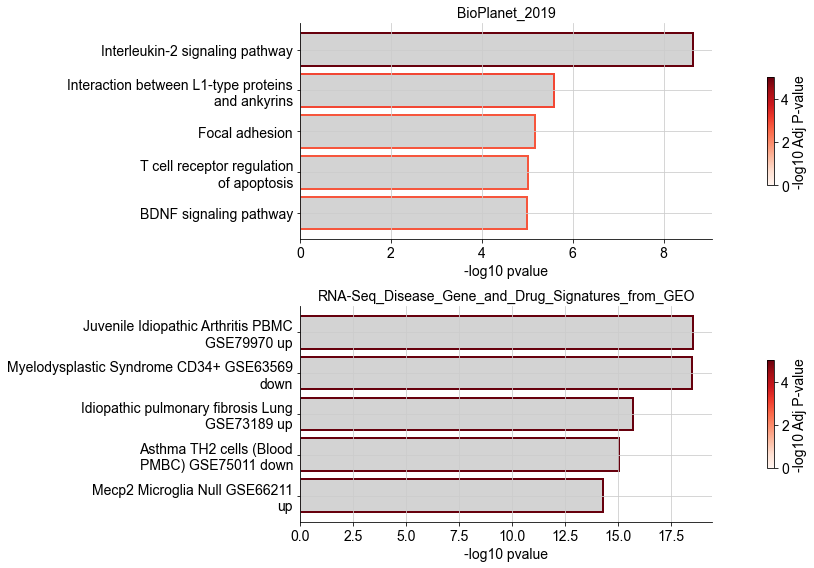

In [22]:
#matplotlib.rc('font', size = 10)
mira.pl.plot_enrichments(nite_enrichments, plots_per_row=1,
                         show_genes = False, show_top = 5,max_genes = 50,
                         aspect=3, height=4)

plt.savefig('Single_Cell/MIRA/figures/GSEA_NITE_genes.pdf')

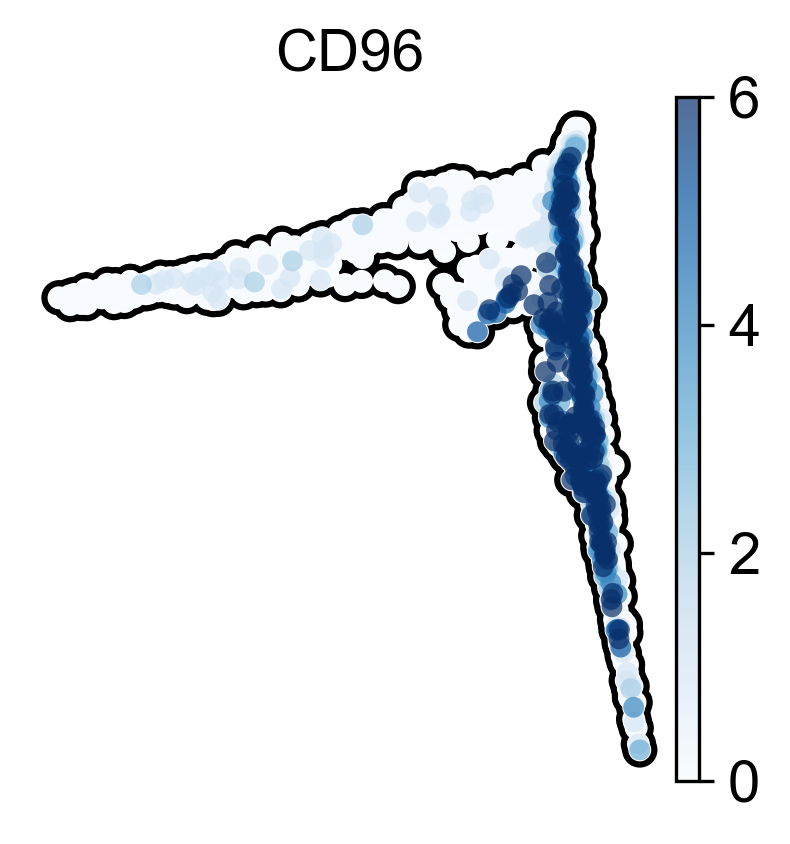

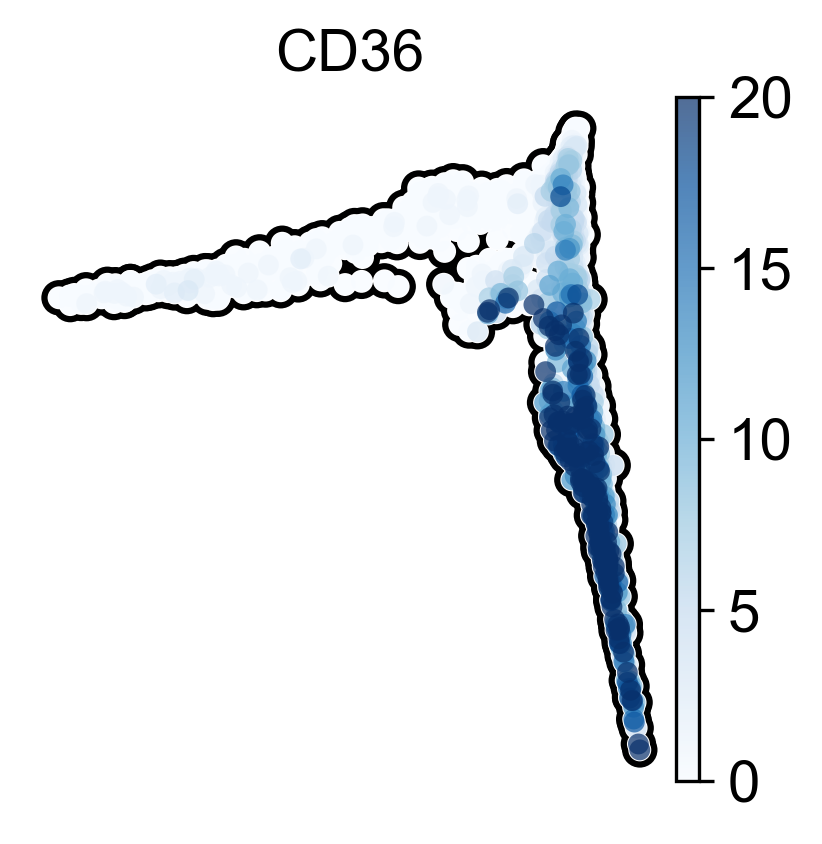

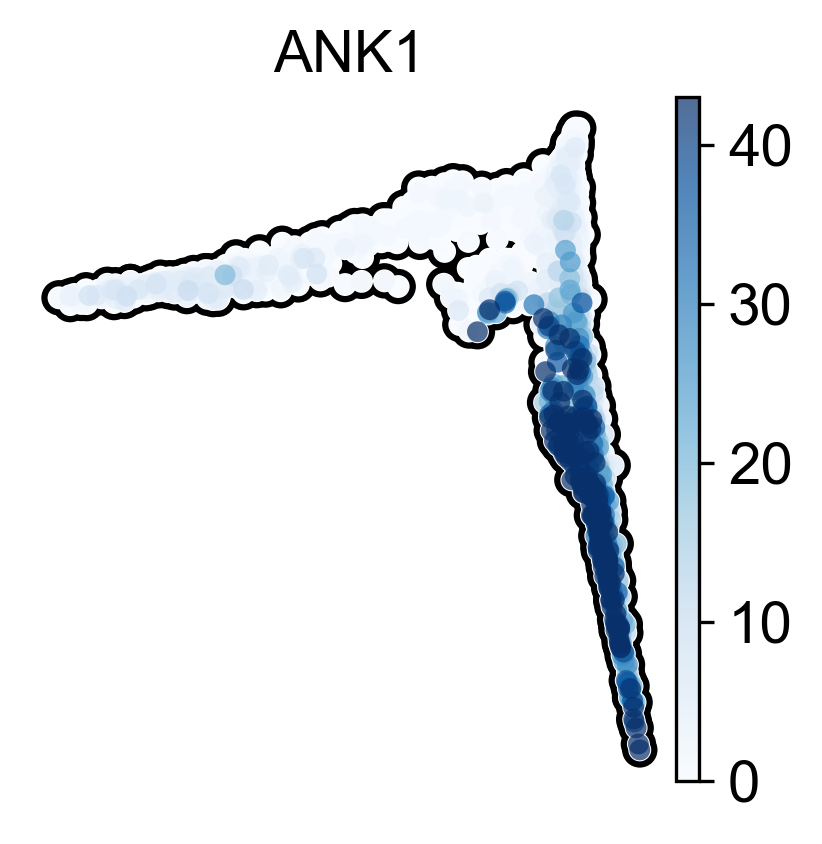

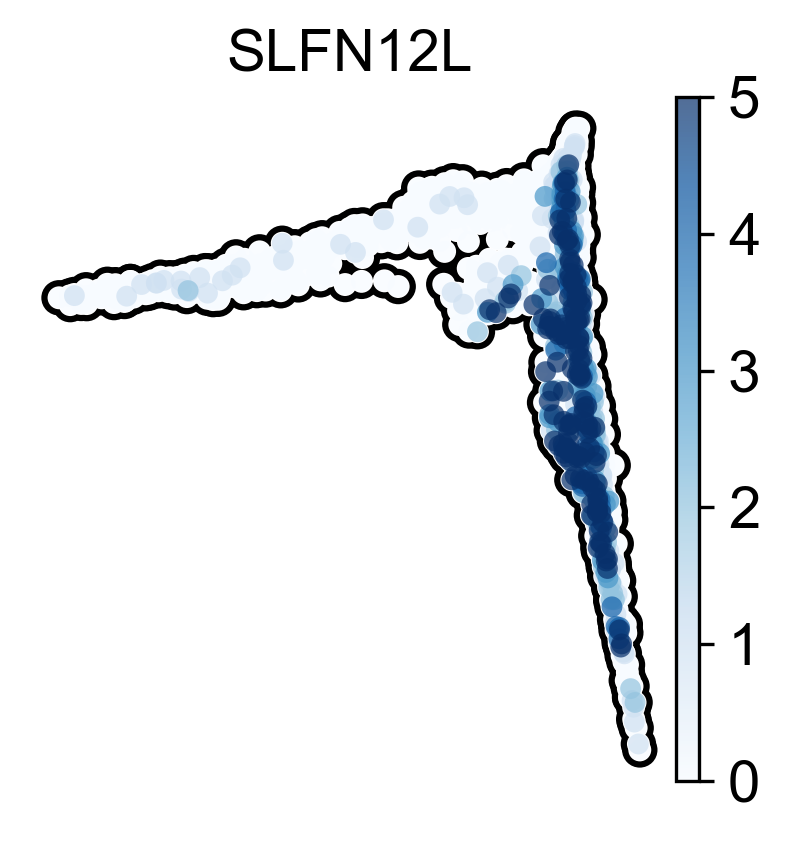

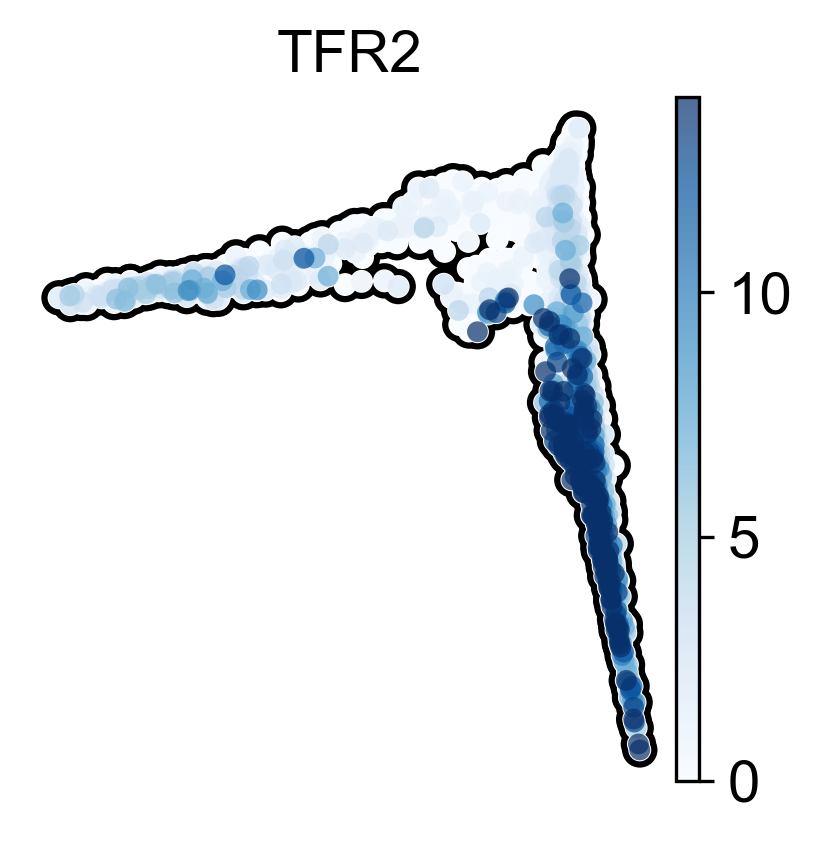

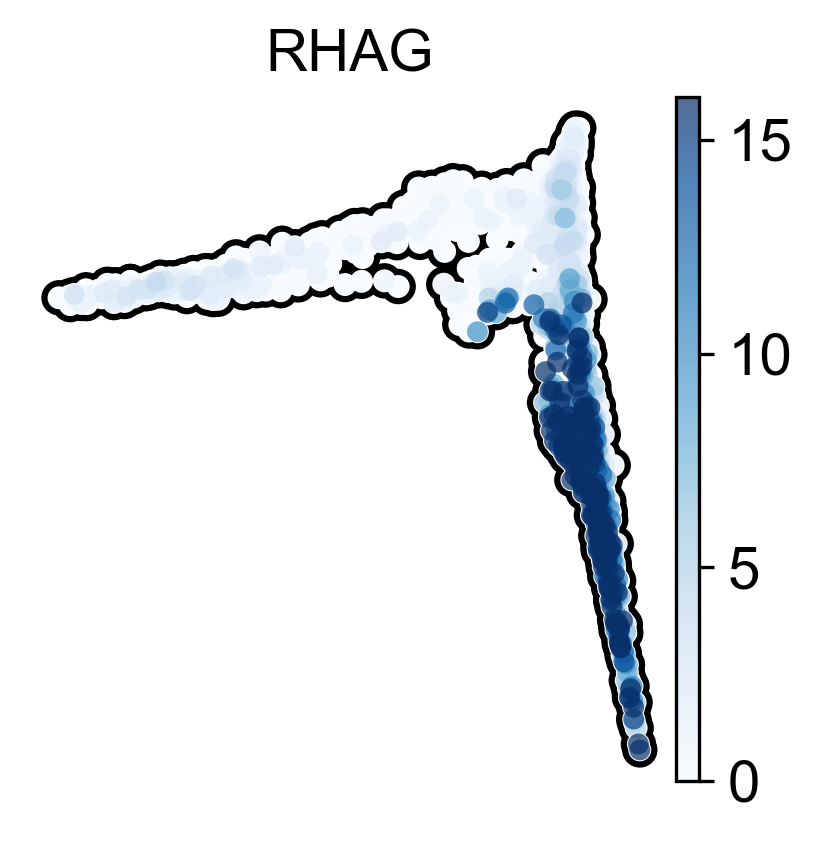

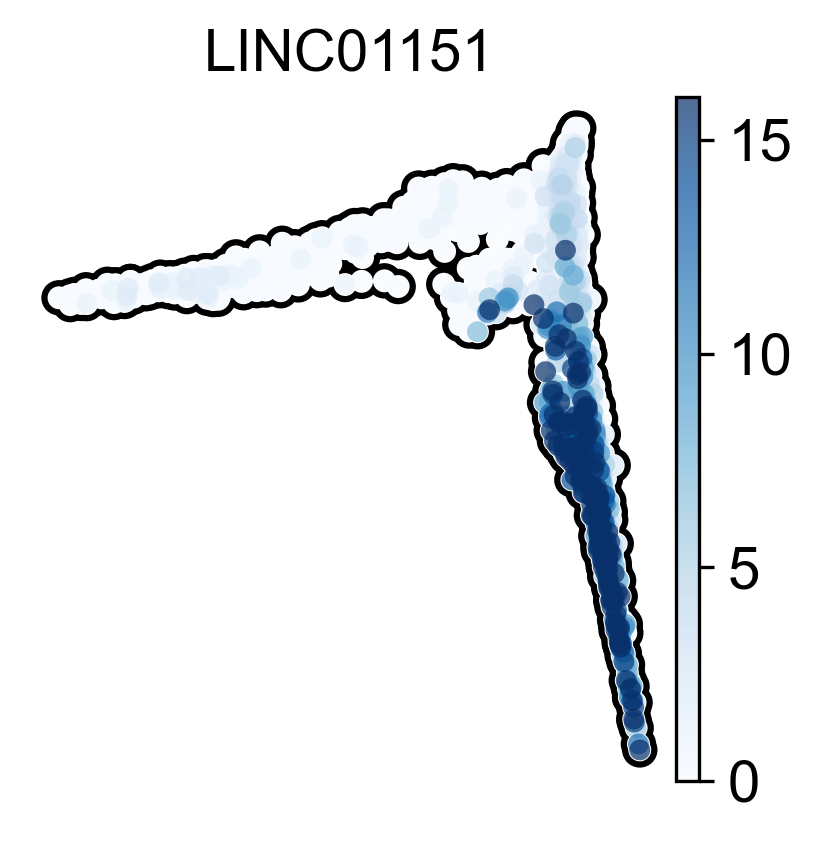

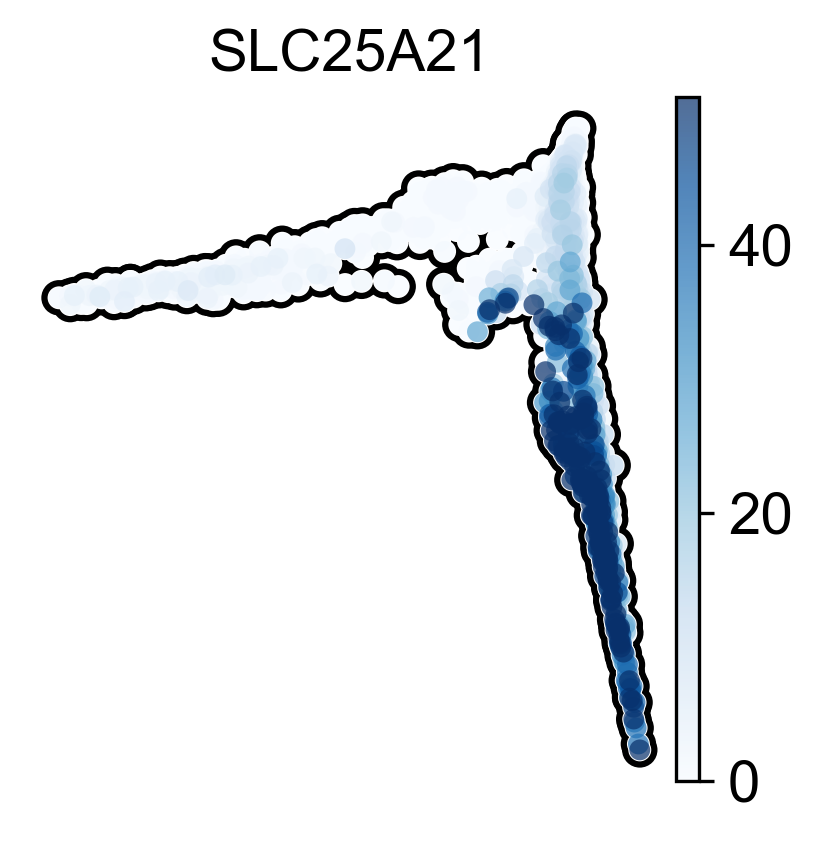

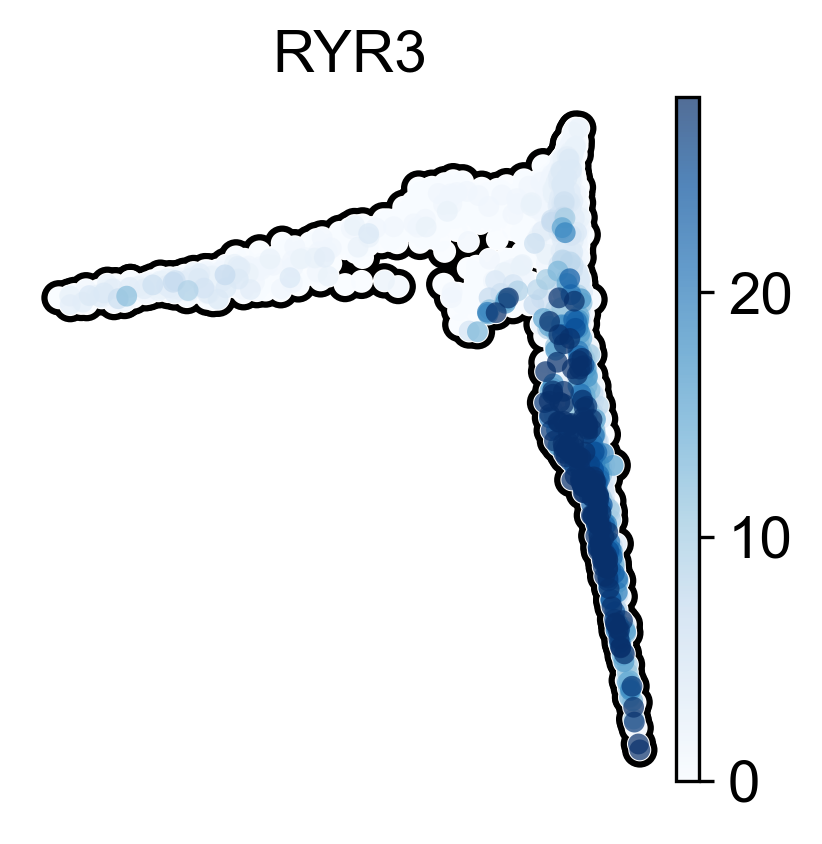

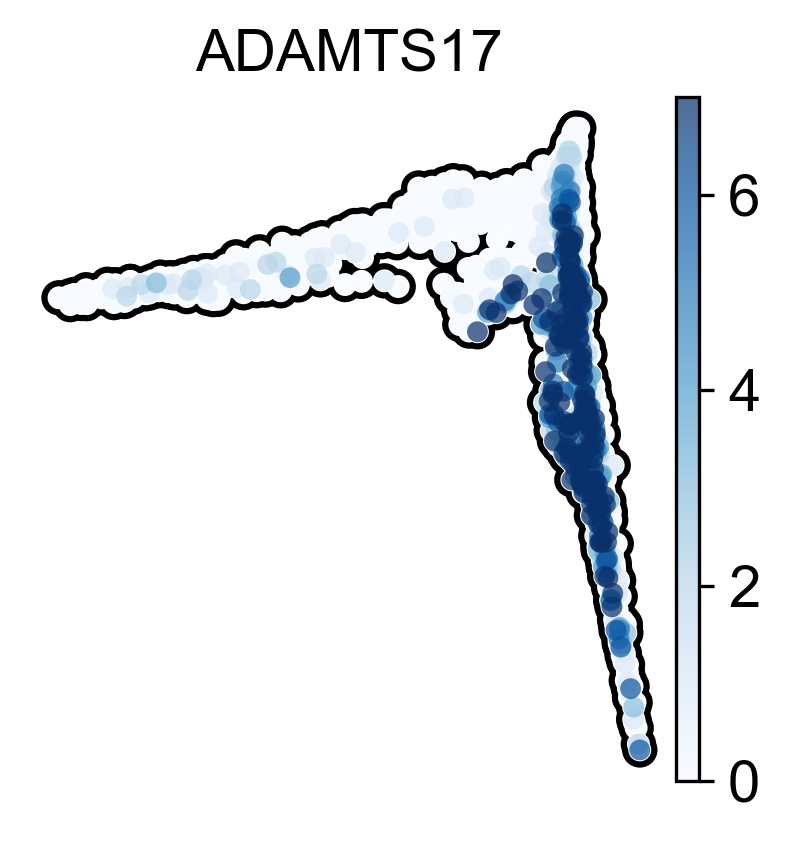

In [23]:
gene_list = ['CD96', 'CD36', 'ANK1', 'SLFN12L', 'TFR2','RHAG','LINC01151',
            'SLC25A21', 'RYR3', 'ADAMTS17']
sc.set_figure_params(figsize=(3,3), dpi=300)

for gene in gene_list:
    check = sc.pl.umap(ndata, color = gene, vmax='p98', vmin = 0, 
                       color_map = 'Blues', return_fig=True, title=gene, 
                       layer='counts',frameon=False, size = 100, add_outline=True)

    plt.savefig('Single_Cell/MIRA/figures/UMAP_' + gene + '_.pdf')

In [11]:
#look at the top NITE genes
nite_genes = pd.DataFrame(ndata.var.NITE_score.dropna())
nite_genes = nite_genes.sort_values(by='NITE_score', ascending=False)
nite_genes.head(20)

,NITE_score
TFR2,340.652995
SLFN12L,273.989194
SLC25A21,265.685427
CD96,265.610502
CD36,255.734555
RHAG,223.665657
ALB,222.235991
MTRNR2L1,217.839118
KEL,207.198956
CTTN,197.946200


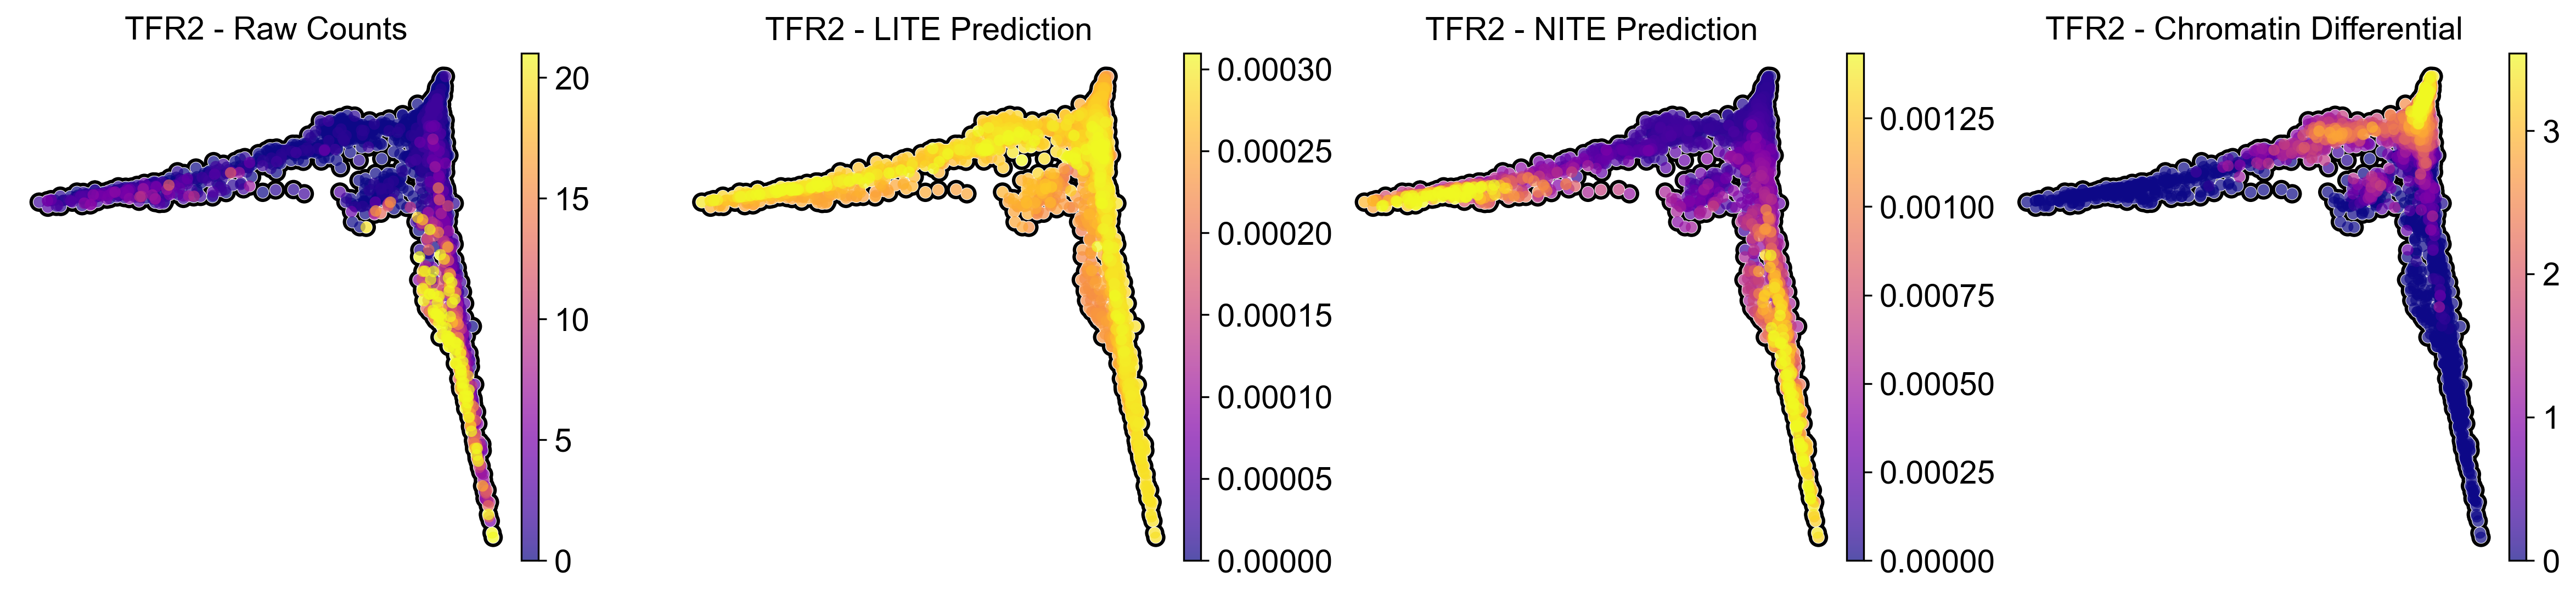

In [14]:
#Compare the LITE and NITE predictions with the raw data for TFR2
gene = 'TFR2'

sc.set_figure_params(figsize=(4,4), dpi=300, dpi_save=400)
sub = ndata[:, [gene]]
sub.obs['Raw Counts'] = pd.DataFrame.sparse.from_spmatrix(sub.layers['counts'])[0].values.to_dense().astype(np.float64)
sub.obs['LITE Prediction'] = pd.DataFrame.sparse.from_spmatrix(sub.layers['LITE_prediction'])[0].values.to_dense().astype(np.float64)
sub.obs['NITE Prediction'] = pd.DataFrame.sparse.from_spmatrix(sub.layers['NITE_prediction'])[0].values.to_dense().astype(np.float64)
sub.obs['Chromatin Differential'] = pd.DataFrame.sparse.from_spmatrix(sub.layers['chromatin_differential'])[0].values.to_dense().astype(np.float64)


fig = sc.pl.umap(sub, color = ['Raw Counts','LITE Prediction','NITE Prediction','Chromatin Differential'], 
                 frameon=False, color_map='plasma',size=100,add_outline=True, legend_loc=None,return_fig=True,
                 ncols=5, vmin = 0, vmax = 'p99', 
                 title = [gene+' - Raw Counts',
                         gene+' - LITE Prediction',
                         gene+' - NITE Prediction',
                         gene+' - Chromatin Differential'])


plt.savefig('Single_Cell/MIRA/figures/TFR2_UMAP_comaprisons.pdf')


In [27]:
#read in the top differentially expressed genes from T21 and Healthy, specifically HSCs
healthy = pd.read_csv('Single_Cell/Raw_Data/Pseudobulk_DESEQ2_out/HSC_DESEQ_Healthy_genes.csv')
healthy = pd.DataFrame(list(healthy.head(300).featurekey))
healthy = healthy.set_index(0)
healthy['NITE'] = ndata.var['NITE_score']
healthy_mean = healthy['NITE'].mean()
healthy_mean

43.62997886520779

In [28]:
#read in the top differentially expressed genes from T21 and Healthy, specifically HSCs
t21 = pd.read_csv('Single_Cell/Raw_Data/Pseudobulk_DESEQ2_out/HSC_DESEQ_T21_genes.csv')
t21 = pd.DataFrame(list(t21.head(300).featurekey))
t21 = t21.set_index(0)
t21['NITE'] = ndata.var['NITE_score']
t21_mean = t21['NITE'].mean()
t21_mean

66.23527841568833

In [52]:
from scipy.stats import mannwhitneyu, normaltest
from pandas.api.types import (
    is_numeric_dtype
)
from scipy.stats import rankdata
from statannotations.Annotator import Annotator

In [30]:
#generate the dataframe to compare the values, need a column with sample information, and a column with NITE information
merged = pd.DataFrame(list(t21.index)+list(healthy.index))
merged = merged.set_index(0)
merged['NITE_score'] = ndata.var['NITE_score']
merged['gene']=merged.index
merged["Condition"] = np.where(merged["gene"].isin(list(t21.index)), "T21", "Healthy")
merged

,NITE_score,gene,Condition
0,,,
AC007422.1,NaN,AC007422.1,T21
CSF1,24.681300,CSF1,T21
LRRC24,42.694068,LRRC24,T21
TNFRSF25,43.009736,TNFRSF25,T21
SPHK1,NaN,SPHK1,T21
...,...,...,...
SLC25A33,12.083027,SLC25A33,Healthy
C12orf57,NaN,C12orf57,Healthy
GNPTAB,NaN,GNPTAB,Healthy


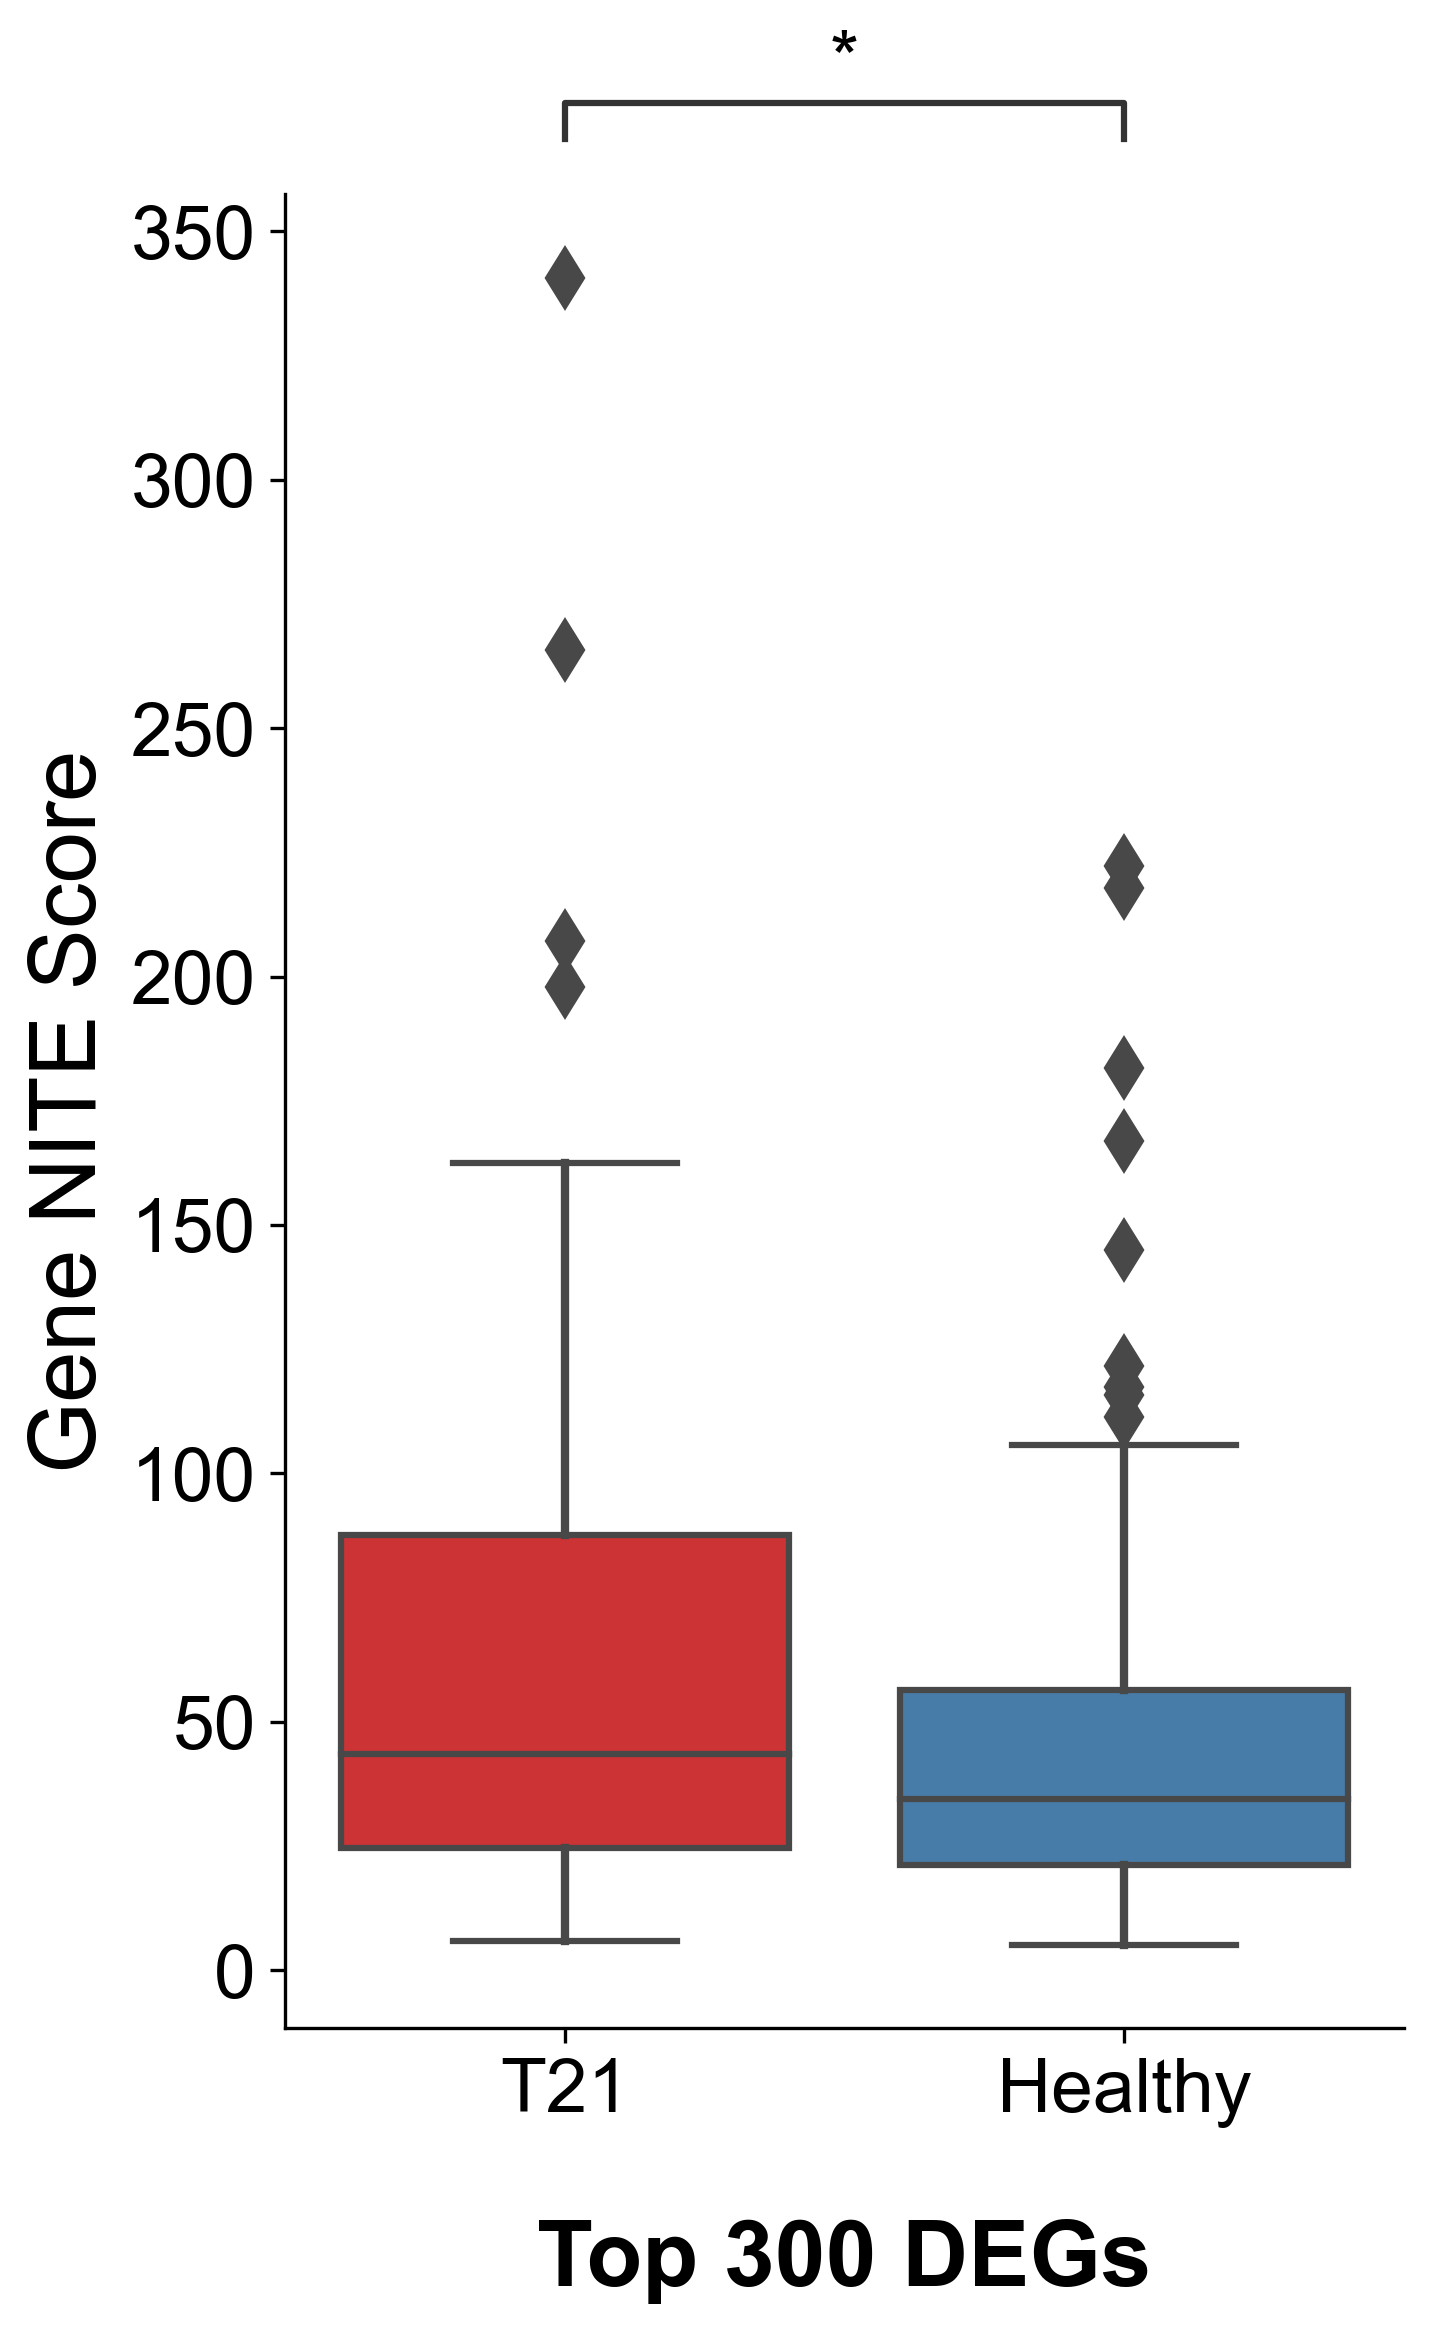

In [270]:
#generate violin plots to compare
colors_list = ['#E41A1C','#377EB8']

hue_plot_params = {
    'data':      merged,
    'x':         'Condition',
    'y':         'NITE_score',
    "palette":   colors_list
}

pairs = (
    [('T21'), ('Healthy')], 
)

               
fig = plt.figure(figsize=(5, 8))
ax = sns.boxplot(x=merged.Condition, y=merged.NITE_score, data=merged, palette=colors_list,
                   whiskerprops={'linewidth': 2}, flierprops = dict( markersize=10))

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles[0:], labels=labels[0:], loc="upper left", fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)


annotator = Annotator(ax, pairs, **hue_plot_params)  
annotator.configure(test="Mann-Whitney", comparisons_correction="BH", fontsize=18,
                    verbose=False, loc='outside').apply_and_annotate()


ax.set_ylabel("Gene NITE Score", fontsize=22)
ax.set_xlabel("Top 300 DEGs", fontsize=22, fontweight="bold")
ax.xaxis.labelpad = 22
sns.despine()

ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
ax.grid(False)
plt.tight_layout()
plt.savefig('Single_Cell/MIRA/figures/DEGs_HSCs_conditions_NITE.png', dpi=300)
plt.show()
